# Defining CDW

This code uses the age tracer to define the Circumpolar Deep Waters (CDW). Specifically, the points along the contour, in density space, with normalized age above 0.9, will be taken as CDW

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(memory_limit='1200gb',n_workers=48)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 52.39 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42711,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 52.39 TiB
Comm: tcp://127.0.0.1:37641,Total threads: 1
Dashboard: /proxy/44649/status,Memory: 1.09 TiB
Nanny: tcp://127.0.0.1:36281,


In [3]:
# Load the along-slope velocity field
#u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')

# this is the new one:
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/Binned_Antarctic_slope_contour_1km_velocities*')


# Load CSHT field
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*')
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')

#importing u_along in thin bins
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*').resample(time='1M').mean()
u_along_unbinned_fine.u_along_contour
print('imported monthly mean ASC speed along contour')

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engin

imported monthly mean ASC speed along contour


Binning the CSHT into 10deg bins

In [4]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHT_along.lon_bin_midpoints[0], CSHT_along.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHT_along.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])

In [5]:
import warnings
warnings.filterwarnings('ignore')

#binning CHST into 10 degrees bins
#creating a halo
CSHT_halo = xr.concat([CSHT_along_fine.binned_cross_slope_heat_trans,CSHT_along_fine.binned_cross_slope_heat_trans.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08
CSHT_along_10deg = CSHT_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 


#now for the CSHT + zonal convergence
CSHTZC_halo = xr.concat([(CSHT_along_fine.binned_cross_slope_heat_trans +CSHT_along_fine.zonal_convergence),\
                         (CSHT_along_fine.binned_cross_slope_heat_trans +CSHT_along_fine.zonal_convergence)\
                         .isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08

CSHTZC_along_10deg = CSHTZC_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 

del CSHT_halo, CSHTZC_halo
#now for the CSHT + zonal convergence in the water mass bins
CSHTZC_halo = xr.concat([(CSHT_along.binned_cross_slope_heat_trans +CSHT_along.zonal_convergence),\
                         (CSHT_along.binned_cross_slope_heat_trans +CSHT_along.zonal_convergence)\
                         .isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08

CSHTZC_along_10degWM = CSHTZC_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 

CSHT_along_10deg.load()
CSHTZC_along_10deg.load()
CSHTZC_along_10degWM.load()

print('cross slope heat transports binned into 10degree bins')


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: bitmask sparsity=0.5138888888888888, merge=False, choosing 'map-reduce'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: bitmask sparsity=0.5138888888888888, merge=False, choosing 'map-reduce'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex 

cross slope heat transports binned into 10degree bins


In [6]:
# Importing regimes and water mass masks
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc').regimes_mask
clustering_mask = clustering_mask.rename({'lon':'lon_bin_midpoints'})
CDW_mask_byMaxdens = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/CDW_mask.nc')['CDW_mask']
DSW_mask_byMaxdens = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DSW_mask.nc')['DSW_mask']
AASW_mask_byMaxdens = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/AASW_mask.nc')['AASW_mask']

In [7]:
#getting correction factor for the CSHT
factor = 1/((CSHT_along.zonal_convergence + CSHT_along.binned_cross_slope_heat_trans)\
.mean('time').sum()/ (CSHT_along.unbinned_heat_transp_across_contour.mean('time').sum()))

We will comapre the age definition with previously discussed water masses definitions....

- Definition 1: Previously discussed maximum density along the contntour CHeck ([check this GH comment](https://github.com/willaguiar/ASC_and_heat_transport/issues/40#issuecomment-2290534967))
- Definition 2: Density level across 10deg zonal bins where the CSHT becomes southward (negative)
- Definition 3: Oldest water aprcel in each point along the contour, in density space

In [8]:
#CSHT in z space
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

CSHTZC_z_monthly =( (CSHTZC_z.binned_cross_slope_heat_trans + CSHTZC_z.zonal_convergence)*0.08 ).resample(time='1M').mean()

CSHT_z_monthly =( (CSHTZC_z.binned_cross_slope_heat_trans)*0.08 ).resample(time='1M').mean()


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


In [9]:
CSHT_z_monthly.load()
CSHTZC_z_monthly.load()
print("loaded CHST in z* coords")

loaded CHST in z* coords


Creating the maks for the CSHT and CSHT + ZC. These will be used in locating the values of density, age, T and S along the contour under the definition 3

In [10]:
#mask for CSHT alone
CSHT_Z_mask = CSHT_z_monthly.mean('time'); CSHT_Z_mask=(CSHT_Z_mask.where(CSHT_Z_mask!=0)*0)+1
#mask for CSHT +zv
CSHTZC_Z_mask = CSHTZC_z_monthly.mean('time'); CSHTZC_Z_mask=(CSHTZC_Z_mask.where(CSHTZC_Z_mask!=0)*0)+1

## Definition 1


In [11]:
# Masking U_along by water mass
Def1_u_along_DSW = (u_along.U_along_contour_binned * DSW_mask_byMaxdens) * clustering_mask
Def1_u_along_CDW = (u_along.U_along_contour_binned * CDW_mask_byMaxdens) * clustering_mask
Def1_u_along_AASW = (u_along.U_along_contour_binned * AASW_mask_byMaxdens) * clustering_mask

# Masking CSHT, binned, without ZC, by water mass
Def1_CSHT_DSW = (CSHT_along.binned_cross_slope_heat_trans * factor) * DSW_mask_byMaxdens * clustering_mask
Def1_CSHT_CDW = (CSHT_along.binned_cross_slope_heat_trans * factor) * CDW_mask_byMaxdens * clustering_mask
Def1_CSHT_AASW = (CSHT_along.binned_cross_slope_heat_trans * factor) * AASW_mask_byMaxdens * clustering_mask


# Masking CSHT, binned, WITH ZC, by water mass
Def1_CSHT_ZC_DSW = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * DSW_mask_byMaxdens * clustering_mask
Def1_CSHT_ZC_CDW = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * CDW_mask_byMaxdens * clustering_mask
Def1_CSHT_ZC_AASW = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * AASW_mask_byMaxdens * clustering_mask

In [12]:
#Finding maximum density
Def1_CSHT_CDW_maxsigma = Def1_CSHT_CDW.sum('regime').resample(time='1M').mean().mean('time')
Def1_CSHT_CDW_maxsigma = Def1_CSHT_CDW_maxsigma.where( Def1_CSHT_CDW_maxsigma!=0)
Def1_CSHT_CDW_maxsigma = ((Def1_CSHT_CDW_maxsigma*0)+1) * Def1_CSHT_CDW_maxsigma.potrho0
Def1_CSHT_CDW_maxsigma =Def1_CSHT_CDW_maxsigma.max('potrho0').load()
Def1_CSHT_CDW_maxsigma_mean = Def1_CSHT_CDW_maxsigma

#Finding minimum density
Def1_CSHT_CDW_minsigma = Def1_CSHT_CDW.sum('regime').resample(time='1M').mean().mean('time')
Def1_CSHT_CDW_minsigma = Def1_CSHT_CDW_minsigma.where( Def1_CSHT_CDW_minsigma!=0)
Def1_CSHT_CDW_minsigma = ((Def1_CSHT_CDW_minsigma*0)+1) * Def1_CSHT_CDW_minsigma.potrho0
Def1_CSHT_CDW_minsigma =Def1_CSHT_CDW_minsigma.min('potrho0').load()
Def1_CSHT_CDW_minsigma_mean = Def1_CSHT_CDW_minsigma

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: blockwise is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


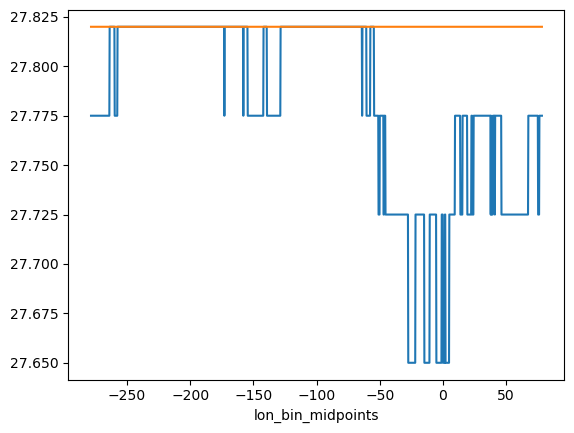

In [13]:
Def1_CSHT_CDW_minsigma_mean.plot()
Def1_CSHT_CDW_maxsigma_mean.plot()


In [14]:
#mean ASC speed per water mass layer 
Def1_u_along_DSW_mean = Def1_u_along_DSW.mean('time').mean(('potrho0','lon_bin_midpoints'))
Def1_u_along_CDW_mean = Def1_u_along_CDW.mean('time').mean(('potrho0','lon_bin_midpoints'))
Def1_u_along_AASW_mean = Def1_u_along_AASW.mean('time').mean(('potrho0','lon_bin_midpoints'))

#total CSHT per water mass layer
Def1_CSHT_DSW_mean = Def1_CSHT_DSW.mean('time').sum(('potrho0','lon_bin_midpoints'))
Def1_CSHT_CDW_mean = Def1_CSHT_CDW.mean('time').sum(('potrho0','lon_bin_midpoints'))
Def1_CSHT_AASW_mean = Def1_CSHT_AASW.mean('time').sum(('potrho0','lon_bin_midpoints'))

#total CSHT + zc per water mass layer
Def1_CSHT_ZC_DSW_mean = Def1_CSHT_ZC_DSW.mean('time').sum(('potrho0','lon_bin_midpoints'))
Def1_CSHT_ZC_CDW_mean = Def1_CSHT_ZC_CDW.mean('time').sum(('potrho0','lon_bin_midpoints'))
Def1_CSHT_ZC_AASW_mean = Def1_CSHT_ZC_AASW.mean('time').sum(('potrho0','lon_bin_midpoints'))

In [15]:
%%time
#loading values.
Def1_u_along_DSW_mean.load()
Def1_u_along_CDW_mean.load()
Def1_u_along_AASW_mean.load()
Def1_CSHT_DSW_mean.load()
Def1_CSHT_CDW_mean.load()
Def1_CSHT_AASW_mean.load()
Def1_CSHT_ZC_DSW_mean.load()
Def1_CSHT_ZC_CDW_mean.load()
Def1_CSHT_ZC_AASW_mean.load()

CPU times: user 2min 42s, sys: 25.9 s, total: 3min 8s
Wall time: 4min 15s


<xarray.DataArray (regime: 3)> Size: 24B
array([-1.47808563e+13,  3.02429694e+12, -5.65174888e+13])
Coordinates:
  * regime   (regime) <U7 84B 'Surface' 'Reverse' 'Deep'

## Definition 2

We will use the maximum positive transport to identify the density level where the CSHT changes from positive to negative, using daily data

In [ ]:
CSHT_along_10deg = CSHT_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'})

In [ ]:

rhomax=np.zeros([36,])*np.nan
valmax=np.zeros([36,])*np.nan
# extracts the density bin with the maximum sumulative heat transport, i.e., the peak of the curve

for nbin in np.arange(0,36):
    rhomax_ind = CSHT_along_10deg.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
    .cumsum('potrho0').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0))).mean('time').isel(lon_bins=nbin).argmax()
    valmax_ind = CSHT_along_10deg.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
    .cumsum('potrho0').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
    .mean('time').isel(lon_bins=nbin).max()
    
    rhomax[nbin]=CSHT_along_10deg.potrho0.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))[rhomax_ind]
    valmax[nbin]=valmax_ind
    #if the heat transport is negative in the entirety of the bin, the level chosen will be 27.84:
    if valmax_ind==0:
        rhomax[nbin]=27.84

#Whenever the desity of reversal is bugger thatn 27.84, we will also chose 27.84
Def2_CDW_max_dens =  np.where(rhomax<=27.84,rhomax,27.84) #any densiy bigger than 27.84, becomes 27.84

Taking a look at the CDW definition 2

In [ ]:
figure = plt.figure(num = 1, figsize = (10, 16))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.subplot(3,1,1)
rate_bins=3
for n in np.arange(0,36,rate_bins):
    (CSHT_along_10deg.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
     .cumsum('potrho0').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
    .mean('time').isel(lon_bins=n)/1e12).plot(y='potrho0',color=[(n+1)/36,0,0],label = str(CSHT_along_10deg.lon_bins[n].values))
    plt.scatter(valmax[n]/1e12,rhomax[n],color=[(n+1)/36,0,0],edgecolors='tab:blue',s=100)
plt.ylim(28.2,27); plt.legend(bbox_to_anchor=(1.3, 1.1),fontsize=18)
plt.grid(); plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel(r'$TW$',fontsize=18); plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title('[a] CSHT, per longtitude bin')

plt.subplot(3,1,2)
plt.plot(lon_bin_mid,rhomax,color='tab:red',label=r'Turning $\sigma_0$')
plt.plot(lon_bin_mid,Def2_CDW_max_dens,color='tab:green',label=r'CDW''s $\sigma^max$')
plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel('Longitude bin',fontsize=18)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title(r'[b]  Densest CDW treshold') 
plt.legend(bbox_to_anchor=(1.3, 1.1),fontsize=14)
plt.ylim(28.2,26.5);


plt.subplot(3,1,3)
CF = CSHT_along_10deg.mean('time').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0))).\
cumsum('potrho0').plot(x='lon_bins', vmin=-5e12,vmax=5e12,cmap='seismic',add_colorbar=False)
plt.scatter(lon_bin_mid,Def2_CDW_max_dens,color='tab:green',s=100)
plt.ylim(28,26.8);
cbar=plt.colorbar(CF)
cbar.ax.set_ylabel(r'$W$')
plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel('Longitude bin',fontsize=18)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title(r'[c]  Turning point along the contour') 

Sometimes the turning point is too light (e.g., around -130, and -100), or we have heat inflow in density layers bigger than heat export (e.g., around -130) and in those cases the method is not propaerly identifying heat influx. In other cases the heat transport is fully negative ( ~ +40). THose cases will be identified as anty thurning point where $\sigma_0<27.6$, and the turning point will become 27.84. **That will bring back the NaN problems in certain parts of the contour**

In [ ]:
#corrected densities will be
Def2_CDW_max_dens_corr =  np.where(Def2_CDW_max_dens>=27.6,Def2_CDW_max_dens,27.84)

In [ ]:
figure = plt.figure(num = 1, figsize = (10, 16))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.subplot(3,1,1)
rate_bins=3
for n in np.arange(0,36,rate_bins):
    (CSHT_along_10deg.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
     .cumsum('potrho0').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
    .mean('time').isel(lon_bins=n)/1e12).plot(y='potrho0',color=[(n+1)/36,0,0],label = str(CSHT_along_10deg.lon_bins[n].values))
    plt.scatter(valmax[n]/1e12,rhomax[n],color=[(n+1)/36,0,0],edgecolors='tab:blue',s=100)
plt.ylim(28.2,27); plt.legend(bbox_to_anchor=(1.3, 1.1),fontsize=18)
plt.grid(); plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel(r'$TW$',fontsize=18); plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title('[a] CSHT, per longtitude bin')

plt.subplot(3,1,2)
plt.plot(lon_bin_mid,rhomax,color='tab:red',label=r'Turning $\sigma_0$')
plt.plot(lon_bin_mid,Def2_CDW_max_dens_corr,color='tab:green',label=r'CDW''s $\sigma^max$')
plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel('Longitude bin',fontsize=18)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title(r'[b]  Densest CDW treshold, *CORRECTED*') 
plt.legend(bbox_to_anchor=(1.3, 1.1),fontsize=14)
plt.ylim(27.9,27.6);


plt.subplot(3,1,3)
CF = CSHT_along_10deg.mean('time').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0))).\
cumsum('potrho0').plot(x='lon_bins', vmin=-5e12,vmax=5e12,cmap='seismic',add_colorbar=False)
plt.scatter(lon_bin_mid,Def2_CDW_max_dens_corr,color='tab:green',s=100)
plt.ylim(27.95,27.6);
cbar=plt.colorbar(CF)
cbar.ax.set_ylabel(r'$W$')
plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel('Longitude bin',fontsize=18)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title(r'[c]  Turning point along the contour, *CORRECTED*') 

The lightest CDW definition will be taken as the minimum (along time) density in the bottom cell of each longitude bin. let gather that


In [ ]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ylength=580

In [ ]:
# #this cell below mygh take a good time to run

#unbinned mask
unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour.isel(time=0)
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)


#density
potrho_transect = cc.querying.getvar(iaf_cycle3,'pot_rho_0' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
potrho_transect = potrho_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask



In [ ]:
%%time
#dzt
dzt_transect= cc.querying.getvar(iaf_cycle3,'dzt' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
dzt_transect = dzt_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

#area
area_transect= cc.querying.getvar(iaf_cycle3,'area_t' , session,n=1).isel(yt_ocean=slice(0,ylength))
area_transect = area_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask
area_transect = area_transect.drop('time')

#volume will be
vol_transect = area_transect * dzt_transect


#loading data
dzt_transect.load()
area_transect.load()
vol_transect.load()
potrho_transect.load()

print('unbinned volumes extracted along contour')

In [ ]:
#binning into 3deg
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)

n_bin_edges = len(full_lon_coord)
lon_along_contour = np.array(CSHTZC_z.lon_along_contour.isel(st_ocean=0,time=0))
lat_along_contour = np.array(CSHTZC_z.lat_along_contour.isel(st_ocean=0,time=0))
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

# average the densities along the contour, in the z space
vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
potrho_transect = potrho_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
σ_contour_3deg = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    σ_contour_3deg0 = potrho_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((σ_contour_3deg0 *0)+1) *distance_along0
    σ_contour_3deg[:,:,lon_bin] = (np.nansum(σ_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
σ_contour_3degnp = np.where(σ_contour_3deg!=0,σ_contour_3deg,np.nan) - 1000



In [ ]:
#densities
σ_contour_3deg = CSHTZC_z_monthly.copy()
σ_contour_3deg.name = 'Density'
σ_contour_3deg.values = σ_contour_3degnp

In [ ]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)

In [ ]:
#getting the sum of the volume in 3 deg bins, z coods

vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_contour_3deg_z = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0_z = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg_z[:,:,lon_bin] = (np.nansum(vol_contour_3deg0_z,axis=2))

#removing zeros
vol_contour_3degnp_z = np.where(vol_contour_3deg_z!=0,vol_contour_3deg_z,np.nan)

In [ ]:
#volume_z
vol_contour_3deg_z = CSHTZC_z_monthly.copy()
vol_contour_3deg_z.name = 'Volume'
vol_contour_3deg_z.values = vol_contour_3degnp_z


In [ ]:
# creating the volume array for a proper weighted mean, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_z_halo = xr.concat([vol_contour_3deg_z,vol_contour_3deg_z.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_z_halo['lon_bin_midpoints'] = longfix

vol_10deg_binned_z = vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning sigma into 10 degrees bins, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
σ_contour_3deg_halo = xr.concat([σ_contour_3deg,σ_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
σ_contour_3deg_halo['lon_bin_midpoints'] = longfix

σ_contour_3deg_halo = σ_contour_3deg_halo* vol_contour_3deg_z_halo #contour density multiplied by the volume in z coordinates

σ_10deg_binned = σ_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# do we want just the time minimum bottom density? (TRUE) or do we want the nth to the bottom(FALSE)?
mindecision =False
nbottom = 2 #number of cells away from the bottom to chose

if mindecision:
    print('We are using the bottom cell')
    max_depth = (((σ_10deg_binned*0)+1) * σ_10deg_binned.st_ocean).max('st_ocean')
    bottom_potrho = σ_10deg_binned.sel(st_ocean=max_depth)
    min_bottom_potrho = bottom_potrho.min('time')
else:
    #Finding maximum depth
    #notice we rolled the ST_ocean so we can get the second deepest cell instead of the deppeest one
    max_depth = (((σ_10deg_binned*0)+1) * σ_10deg_binned.st_ocean).max('st_ocean')
    # which level in the water column do we want?
    print('we are using the ' +str(nbottom) + 'th bottom cell')
    for n in range(nbottom):
        #Extracting densities at maximum depth
        bottom_potrho = σ_10deg_binned.where(σ_10deg_binned.st_ocean<max_depth)#.max('st_ocean') #this is the second maximum along depth. it assumes the maximum density is always in the bottom
        max_depth = (((bottom_potrho*0)+1) * bottom_potrho.st_ocean).max('st_ocean') #second deepest cell deepest cell
        bottom_potrho = σ_10deg_binned.where(σ_10deg_binned.st_ocean<max_depth).max('st_ocean') #this is the third maximum verticically
        min_bottom_potrho = bottom_potrho.min('time')


We can see that these approaches still clash west of -190. Some some adjutment is doe there. That means in those cases we either have  increase the maximum density limit of CDW, or decrease the minimum density limit. Since $\sigma_{max}$ west of the Antarctic peninsula seem to be to light.... they will then be eddited to be 27.84.



In [ ]:
#corrected densities will be
#Def2_CDW_max_dens_corr =  np.where(Def2_CDW_max_dens>=27.4,Def2_CDW_max_dens,min_bottom_potrho)

Def2_CDW_min_dens = min_bottom_potrho
flag = Def2_CDW_max_dens_corr-min_bottom_potrho

Def2_CDW_max_dens_doublecorr =  np.where(flag>0,Def2_CDW_max_dens_corr,27.84)

In [ ]:
##### DONT FORGET TO UNCOMMENT THIS LINE LATER ###########
#I was talking to Ellie, which suggested fixing the CDW bottom limit to be 27.84. lets try that

# Def2_CDW_max_dens_doublecorr = (Def2_CDW_max_dens_doublecorr*0)+27.84

how does the minimum an dmaximum densities look together?

In [ ]:
plt.step(lon_bin_mid,min_bottom_potrho,\
         linewidth=2,where='mid',color='tab:green',label=r'CDW''s $\sigma^{min}$')

plt.step(lon_bin_mid,Def2_CDW_max_dens_corr,\
         linewidth=2,where='mid',color='tab:red',label=r'CDW''s $\sigma^{max}$')
plt.step(lon_bin_mid,Def2_CDW_max_dens_doublecorr,\
         linewidth=2,where='mid',color='indigo',\
         linestyle='--',label=r'CDW''s $\sigma^{max}_{corrected}$')

plt.legend()
plt.ylim(27.85,27.6)

## Definition 3

For this definition we will need to extract the values of $\sigma_0$, $age$, $T$, and $S$ along the contour, at the exact same spots as the CSHT and their ZC

In [ ]:
#age from the end of iaf  yle 2, to appemnd to the cycle 3
age_transect_IC= cc.querying.getvar('01deg_jra55v140_iaf_cycle2','age_global' , session,n=-1)\
.isel(yt_ocean=slice(0,ylength)).isel(time=-1)

age_transect_IC = age_transect_IC.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

age_transect_IC.load()

In [ ]:
%%time

#age 
age_transect= cc.querying.getvar(iaf_cycle3,'age_global' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
age_transect = age_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask


age_transect = age_transect  + age_transect_IC

#temp
temp_transect = cc.querying.getvar(iaf_cycle3,'temp' , session,\
                                        frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength)) -273.25
temp_transect = temp_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

#salinity
salt_transect= cc.querying.getvar(iaf_cycle3,'salt' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
salt_transect = salt_transect.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

potrho_transect.load()
age_transect.load()
temp_transect.load()
salt_transect.load()

print('unbinned values extracted along contour')

interpolating the density into the same grid as the heat transport. that is required so the depths match between arrays

In [ ]:
CSHT_day1 = CSHTZC_z.unbinned_heat_transp_across_contour.isel(time=0).load()

Let's make sure the contours match

In [ ]:
figure = plt.figure(num = 1, figsize = (8, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.subplot(2,1,1)
potrho_transect.isel(time=-1).plot(x='contour_index')
plt.ylim(1500,0)

plt.subplot(2,1,2)
CSHT_day1.plot(x='contour_index',vmin=-1e11,vmax=1e11,cmap='seismic')
plt.ylim(1500,0)

The conversion to sigma levels in the CSHT was done before doing the 3-degrees binning. Let's then use the xhistogram to convert $T$, $S$, and $age$ into sigma levels

In [ ]:
from xhistogram.xarray import histogram

In [ ]:
potrho_transect.name = 'sigma'
age_transect.name = 'age'
salt_transect.name = 'salt'
temp_transect.name = 'temp'

rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)-1000

In [ ]:
#what is the distance between the points? This will be used as weights for the binning!
lat_along_fordist = CSHTZC_z.lat_along_contour.isel(time=0,st_ocean=0).values
lon_along_fordist = CSHTZC_z.lon_along_contour.isel(time=0,st_ocean=0).values
import geopy.distance
npdistance_along=lon_along_fordist*0
for ncontour in np.arange(0,6001):
    coords_1 = (lat_along_fordist[ncontour], lon_along_fordist[ncontour])
    coords_2 = (lat_along_fordist[ncontour+1], lon_along_fordist[ncontour+1])
    npdistance_along[ncontour] = geopy.distance.geodesic(coords_1, coords_2).km
#last value will be
coords_1 = (lat_along_fordist[-1], lon_along_fordist[-1])
coords_2 = (lat_along_fordist[0], lon_along_fordist[0])
npdistance_along[-1] = geopy.distance.geodesic(coords_1, coords_2).km

distance_along = temp_transect.isel(st_ocean=0,time=0).drop('st_ocean')
distance_along.name='distance'
distance_along.values = npdistance_along

We also need to have the volume along the contour for the density binning

Now we have all variables in the transects we need for the conversion from Z to sigma. Lets use the xhistogram to convert from z to sigma levels along the contour

In [ ]:
#binning age into sigma contours
age_sigma = histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = age_transect*vol_transect)/\
histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)

#binning temp into sigma contours
temp_sigma = histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = temp_transect*vol_transect)/\
histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)

#binning salinity into sigma contours
salt_sigma = histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = salt_transect*vol_transect)/\
histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)


#binning the volume into sigma contours -  This will be used in the future for the 3deg binning

vol_sigma = histogram(potrho_transect-1000, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_transect)

In [ ]:
#importing refined bins CSHT for comparisson, year 2000 only
CSHT_along_fine_2000 = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*2000*').\
resample(time='1M').mean().mean('time')
CSHT_along_fine_2000.load()
print('imported CSHT in refined sigma levels for year 2000')

In [ ]:
CSHT_along_fine_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_rho/*').\
resample(time='1M').mean()
CSHT_along_fine_monthly.load()
print('imported CSHT in refined sigma levels for the whole period')

Next step is to bin into the 3 degrees that is used as the default zonal binning for our analysis

In [ ]:
%%time
u_along_unbinned_fine.load()

In [ ]:
%%time
#binning into 3deg
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)

n_bin_edges = len(full_lon_coord)
lon_along_contour = np.array(CSHT_along_fine_2000.lon_along_contour)
lat_along_contour = np.array(CSHT_along_fine_2000.lat_along_contour)
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

# average the densities along the contour, in the z space
vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
potrho_transect = potrho_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
σ_contour_3deg = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    σ_contour_3deg0 = potrho_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((σ_contour_3deg0 *0)+1) *distance_along0
    σ_contour_3deg[:,:,lon_bin] = (np.nansum(σ_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
σ_contour_3degnp = np.where(σ_contour_3deg!=0,σ_contour_3deg,np.nan) - 1000


#averaging the age along the contour, in sigma bins
age_sigma = age_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

age_contour_3deg = np.zeros([732,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    age_contour_3deg0 = age_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((age_contour_3deg0 *0)+1) *distance_along0
    age_contour_3deg[:,:,lon_bin] = (np.nansum(age_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
age_contour_3degnp = np.where(age_contour_3deg!=0,age_contour_3deg,np.nan)


#averaging the temp along the contour, in sigma bins
temp_sigma = temp_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

temp_contour_3deg = np.zeros([732,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    temp_contour_3deg0 = temp_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((temp_contour_3deg0 *0)+1) *distance_along0
    temp_contour_3deg[:,:,lon_bin] = (np.nansum(temp_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
temp_contour_3degnp = np.where(temp_contour_3deg!=0,temp_contour_3deg,np.nan)


#averaging the salt along the contour, in sigma bins
salt_sigma = salt_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

salt_contour_3deg = np.zeros([732,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    salt_contour_3deg0 = salt_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((salt_contour_3deg0 *0)+1) *distance_along0
    salt_contour_3deg[:,:,lon_bin] = (np.nansum(salt_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
salt_contour_3degnp = np.where(salt_contour_3deg!=0,salt_contour_3deg,np.nan)


#getting the sum of the volume in 3 deg bins

vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

vol_contour_3deg = np.zeros([732,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg[:,:,lon_bin] = (np.nansum(vol_contour_3deg0,axis=2))

#removing zeros
vol_contour_3degnp = np.where(vol_contour_3deg!=0,vol_contour_3deg,np.nan)


#getting the sum of the volume in 3 deg bins, z coods

vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_contour_3deg_z = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0_z = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg_z[:,:,lon_bin] = (np.nansum(vol_contour_3deg0_z,axis=2))

#removing zeros
vol_contour_3degnp_z = np.where(vol_contour_3deg_z!=0,vol_contour_3deg_z,np.nan)


#averaging the ASC velocities
U_sigma = u_along_unbinned_fine.u_along_contour.rename({'potrho0':'sigma_bin'}).\
transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing

salt_contour_3deg = np.zeros([732,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    salt_contour_3deg0 = salt_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((salt_contour_3deg0 *0)+1) *distance_along0
    salt_contour_3deg[:,:,lon_bin] = (np.nansum(salt_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
salt_contour_3degnp = np.where(salt_contour_3deg!=0,salt_contour_3deg,np.nan)


#averaging the ASC velocities
U_sigma = u_along_unbinned_fine.u_along_contour.rename({'potrho0':'sigma_bin'}).\
transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
U_sigma['sigma_bin']= vol_sigma.sigma_bin
U_sigma['time']=vol_sigma.time
U_sigma_3deg = np.zeros([732,108,n_bins])*np.nan
for lon_bin in range(n_bins):
    U_sigma_3deg0 = U_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((U_sigma_3deg0 *0)+1) *distance_along0
    U_sigma_3deg[:,:,lon_bin] = (np.nansum(U_sigma_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
U_sigma_3degnp = np.where(U_sigma_3deg!=0,U_sigma_3deg,np.nan)



In [ ]:
#transforming nps into xarrays for easier plotting

#U
U_contour_3deg = CSHT_along_fine_monthly.binned_cross_slope_heat_trans.copy()
U_contour_3deg.name = 'ASCspeed'
U_contour_3deg.values = U_sigma_3degnp


#volume_z
vol_contour_3deg_z = CSHTZC_z_monthly.copy()
vol_contour_3deg_z.name = 'Volume'
vol_contour_3deg_z.values = vol_contour_3degnp_z


#densities
σ_contour_3deg = CSHTZC_z_monthly.copy()
σ_contour_3deg.name = 'Density'
σ_contour_3deg.values = σ_contour_3degnp

#ages
age_contour_3deg = CSHT_along_fine_monthly.binned_cross_slope_heat_trans.copy()
age_contour_3deg.name = 'age'
age_contour_3deg.values = age_contour_3degnp

#temperatures
temp_contour_3deg = CSHT_along_fine_monthly.binned_cross_slope_heat_trans.copy()
temp_contour_3deg.name = 'Temperature'
temp_contour_3deg.values = temp_contour_3degnp

#salinities
salt_contour_3deg = CSHT_along_fine_monthly.binned_cross_slope_heat_trans.copy()
salt_contour_3deg.name = 'Salinity'
salt_contour_3deg.values = salt_contour_3degnp

#volumes_rho
vol_contour_3deg = CSHT_along_fine_monthly.binned_cross_slope_heat_trans.copy()
vol_contour_3deg.name = 'Volume'
vol_contour_3deg.values = vol_contour_3degnp

In [ ]:
figure = plt.figure(num = 1, figsize = (12, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]


plt.subplot(2,1,1)
pc = temp_contour_3deg.isel(time=-1).plot.pcolormesh()


plt.ylim(27.95,27.6);
plt.tick_params(labelsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.grid()

plt.subplot(2,1,2)
CSHT_along_fine_monthly.binned_cross_slope_heat_trans.isel(time=-1).plot.pcolormesh(vmin=-1e10,vmax=1e10,cmap='seismic')
plt.ylim(27.95,27.6); plt.grid()
plt.tick_params(labelsize=14)

In [ ]:
figure = plt.figure(num = 1, figsize = (6, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]


plt.subplot(2,1,1)
pc = σ_contour_3deg.isel(time=0).plot.pcolormesh(levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'])


plt.ylim(1500,0)
plt.tick_params(labelsize=14)
plt.ylabel('Depth (m)',fontsize=14,labelpad=-3)
plt.xlabel('Longitude',fontsize=14)
plt.title('Density along 1000m isobath curtain',fontsize=14)

plt.subplot(2,1,2)
CSHT_z_monthly.isel(time=0).plot.pcolormesh(vmin=-1e10,vmax=1e10,cmap='seismic')
plt.ylim(1500,0)

The contours seem to match, excepth for some really dense values not existing on the $T$, $S$, $age$ in sigma levels, because we used monthly mean sigma to make the conversion

Now that we have the monthly contours of $age$, $T$, $S$ in $\sigma_0$ space, we can rebin them into 10 degrees bins, as it was done with th CSHT

In [ ]:
# creating the volume array for a proper weighted mean, sigma
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_halo = xr.concat([vol_contour_3deg,vol_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_halo['lon_bin_midpoints'] = longfix


vol_10deg_binned = vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# creating the volume array for a proper weighted mean, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_z_halo = xr.concat([vol_contour_3deg_z,vol_contour_3deg_z.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_z_halo['lon_bin_midpoints'] = longfix

vol_10deg_binned_z = vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning sigma into 10 degrees bins, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
σ_contour_3deg_halo = xr.concat([σ_contour_3deg,σ_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
σ_contour_3deg_halo['lon_bin_midpoints'] = longfix

σ_contour_3deg_halo = σ_contour_3deg_halo* vol_contour_3deg_z_halo #contour density multiplied by the volume in z coordinates

σ_10deg_binned = σ_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning ASC speed into 10 degrees bins, rho
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
U_contour_3deg_halo = xr.concat([U_contour_3deg,U_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
U_contour_3deg_halo['lon_bin_midpoints'] = longfix

U_contour_3deg_halo = U_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates

U_10deg_binned = U_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning age into 10 degrees bins, rho
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
age_contour_3deg_halo = xr.concat([age_contour_3deg,age_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
age_contour_3deg_halo['lon_bin_midpoints'] = longfix

age_contour_3deg_halo = age_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates

age_10deg_binned = age_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning temp into 10 degrees bins, rho
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
temp_contour_3deg_halo = xr.concat([temp_contour_3deg,temp_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
temp_contour_3deg_halo['lon_bin_midpoints'] = longfix

temp_contour_3deg_halo = temp_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates

temp_10deg_binned = temp_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning salt into 10 degrees bins, rho
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
salt_contour_3deg_halo = xr.concat([salt_contour_3deg,salt_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
salt_contour_3deg_halo['lon_bin_midpoints'] = longfix

salt_contour_3deg_halo = salt_contour_3deg_halo* vol_contour_3deg_halo #contour density multiplied by the volume in z coordinates

salt_10deg_binned = salt_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


Let's now do a sanity check... first, how does the density curtains look like?

In [ ]:
figure = plt.figure(num = 1, figsize = (12, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]


pc = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'])


plt.ylim(1400,0);
plt.tick_params(labelsize=14)
plt.ylabel('Depth',fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.grid()
plt.title(r'Mean $\sigma_0$ along the contour in 10 degree bins')

What about the $age(\sigma_0)$, how does that look like in comparisson with CSHT in $\sigma_0$ levels

In [ ]:
figure = plt.figure(num = 1, figsize = (12, 11))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

plt.subplot(2,1,1)
pc = age_10deg_binned.isel(time=0).plot.pcolormesh(y='potrho0')


plt.ylim(27.95,27.6);
plt.tick_params(labelsize=14)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.xlabel('Longitude',fontsize=18)
plt.grid()
plt.title(r'Mean $age$ along the contour in 10 degree bins')

plt.subplot(2,1,2)
CSHT_along_10deg.isel(time=0).plot.pcolormesh(vmin=-1e11,vmax=1e11,cmap='seismic')
plt.ylim(27.95,27.6);
plt.grid()
plt.tick_params(labelsize=14)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.xlabel('Longitude',fontsize=18)

Now creating the mask for CDW. that means we need to normalized the age to the maximum in density of each bin and time, and then pick up the 90% level of the age

In [ ]:
age_10deg_binned_normalized = age_10deg_binned/age_10deg_binned.max('potrho0') #normalized age

In [ ]:
# lets also normalized the temperature, and try to use that as a mask
temp_10deg_binned_normalized = (temp_10deg_binned-temp_10deg_binned.min('potrho0'))/\
(temp_10deg_binned-temp_10deg_binned.min('potrho0')).max('potrho0') #normalized age

In [ ]:
# lets also normalized the temperature, and try to use that as a mask
salt_10deg_binned_normalized = (salt_10deg_binned-salt_10deg_binned.min('potrho0'))/\
(salt_10deg_binned-salt_10deg_binned.min('potrho0')).max('potrho0') #normalized age

In [ ]:
weight_temp = 6
weight_age = 2 
weight_salt = 1

tempage_10deg_binned_normalized  = ((temp_10deg_binned_normalized*weight_temp)+\
                                    (age_10deg_binned_normalized*weight_age) +\
                                   (salt_10deg_binned_normalized*weight_salt))/\
(weight_temp+weight_age+weight_salt)

How does the TS diagram look like?

In [ ]:
#ts diagram through xhistogram
sbins = np.arange(34,35, 0.01)
tbins = np.arange(-2, 3, 0.05)

salt_10deg_binned.name='Salinity'
temp_10deg_binned.name='Temperature'
vol_10deg_binned.name='Volume'

hTSage = (histogram(salt_10deg_binned,
                   temp_10deg_binned,
                   bins=[sbins, tbins],
                   weights=age_10deg_binned_normalized*vol_10deg_binned)/
                histogram(salt_10deg_binned,
                          temp_10deg_binned,
                          bins=[sbins, tbins],
                          weights=vol_10deg_binned))


hTStemp = (histogram(salt_10deg_binned,
                   temp_10deg_binned,
                   bins=[sbins, tbins],
                   weights=tempage_10deg_binned_normalized*vol_10deg_binned)/
                histogram(salt_10deg_binned,
                          temp_10deg_binned,
                          bins=[sbins, tbins],
                          weights=vol_10deg_binned))


In [ ]:
#creating colormap
import matplotlib.colors as cl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
orange = np.array([248/256, 100/256, 0/256, 1])
newcolors[-13:, :] = orange #85 = -39: 80%  =52, 90 = -25, 75%=65
newcmp = ListedColormap(newcolors)

In [ ]:
figure = plt.figure(num = 1, figsize = (5, 4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

TS = hTSage.T.plot(vmin=0, vmax=1,cmap=newcmp,add_colorbar=False)
plt.colorbar(TS,ticks=[0,.2,.4,.6,.8,.95,1])
plt.ylabel("Temperature"); plt.xlabel("Salinity")
plt.grid()
plt.xlim(34,34.8); plt.ylim(-2,3)

Defining the mask as the 90% older waters

In [ ]:
agenormbins=np.linspace(0,1,41)
#binning salinity into sigma contours
ageforbin=age_10deg_binned_normalized.rename({'lon_bin_midpoints_bins':'lon_bins'}).copy()
ageforbin.name='age'

cshtzcforbin=CSHTZC_along_10deg.resample(time='1M').mean().rename({'lon_bin_midpoints_bins':'lon_bins'}).copy()
cshtzcforbin.name='csht'
cshtzcforbin
ageforbin['lon_bins']=cshtzcforbin.lon_bins
age_hist = histogram(ageforbin, 
                          bins = agenormbins, 
                          dim = ['potrho0','time','lon_bins'],
                          weights = cshtzcforbin)/732


In [ ]:
figure = plt.figure(num = 1, figsize = (6,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)


plt.barh(age_hist.age_bin,age_hist/1e12,height=.02)
plt.ylabel('Normalized age',fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('CSHT [TW]',fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.ylim()
plt.title('Distribution of CSHT per age category',fontsize=18)
plt.yticks(ticks=[0,0.2,0.4,0.6,0.8,0.95,1])
plt.ylim(1,0)

**As we can see, most of the SOuthward heat transport in old ages happen for normalized ages larger Than 0.95**

In [ ]:
#normalized age limit used to define CDW (either temp, age, or both)
normlimit = 0.95

#CDW mask will be
CDW_age_mask = ((age_10deg_binned_normalized.where(age_10deg_binned_normalized>normlimit)*0)+1)
#AASW mask will be any densities above the CDW
AASW_age_mask= CDW_age_mask.bfill('potrho0') - CDW_age_mask.fillna(0)
AASW_age_mask = AASW_age_mask.where(AASW_age_mask>0)
#DSW will be whatever is left at densities bigger than CDW
DSW_age_mask = (AASW_age_mask.fillna(0)*4) + (CDW_age_mask.fillna(0)*4) + CDW_age_mask.fillna(1)
DSW_age_mask = DSW_age_mask.where(DSW_age_mask<2)

In [ ]:
#example of water mass distribution in a specific time
timeind=100
(CDW_age_mask.isel(time=timeind)*2).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
DSW_age_mask.isel(time=timeind).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
AASW_plot = (AASW_age_mask.isel(time=timeind)*3).plot(y='potrho0',vmin=1,vmax=3,add_colorbar=False,alpha=0.7)
plt.ylim(27.95,27.6);
cbar = plt.colorbar(AASW_plot)
cbar.ax.set_yticks(ticks=[1,2,3],labels=['DSW','CDW','AASW'])

It seems to me that the definitions do not overlap, at any time, as we want it. 

## Comparisson between definitions

To visualize the depth of CDW, we need to reconvert the mask into depth layers. That will be done purely for visualuzation purposes

In [ ]:
st_edges = cc.querying.getvar(iaf_cycle3,'st_edges_ocean' , session,n=1)

In [ ]:
#for that I need an xarray with depth values as a function of time, potrho0 and lon bins
σ_10deg_binned.name='sigma'
vol_10deg_binned.name='volume'
CDW_age_mask.name='CDW'

depth_fsigma = histogram(σ_10deg_binned, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = ((σ_10deg_binned*0)+1)*σ_10deg_binned.st_ocean*vol_10deg_binned_z )/\
histogram(σ_10deg_binned, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_10deg_binned_z)

In [ ]:
#binning salinity into sigma contours
σ_10deg_binned.name='sigma'
vol_10deg_binned.name='volume'
CDW_age_mask.name='CDW'

CDW_mask_depth = histogram(depth_fsigma, 
                          bins = st_edges.values, 
                          dim = ['sigma_bin'],
                          weights = CDW_age_mask.rename({'potrho0':'sigma_bin'}).fillna(0)*vol_10deg_binned.rename({'potrho0':'sigma_bin'}))/\
histogram(depth_fsigma, 
                          bins = st_edges.values, 
                          dim = ['sigma_bin'],
                          weights = vol_10deg_binned.rename({'potrho0':'sigma_bin'}))

CDW_mask_depth_mean = CDW_mask_depth.mean('time')
CDW_mask_depth_mean =(CDW_mask_depth_mean.where(CDW_mask_depth_mean>0)*0)+1 #turning into integerws any values above 0.5 (CDW more than 50% of the time)


In [ ]:
#for the definition 2, we will need to find the sigma in the density curtain...
#maximum and minimum depths as lines
#maximum
CDW_mask_depth_mean0=CDW_mask_depth_mean.copy()
CDW_mask_depth_mean0['histogram_sigma_bin']=st_edges[1:].values
def3_max_depth = ((CDW_mask_depth_mean0*0)+1)*CDW_mask_depth_mean0.histogram_sigma_bin
def3_max_depth =def3_max_depth.max('histogram_sigma_bin')

#minimum
CDW_mask_depth_mean0=CDW_mask_depth_mean.copy()
CDW_mask_depth_mean0['histogram_sigma_bin']=st_edges[:-1].values
def3_min_depth = ((CDW_mask_depth_mean0*0)+1)*CDW_mask_depth_mean0.histogram_sigma_bin
def3_min_depth =def3_min_depth.min('histogram_sigma_bin')

In [ ]:
#for the definition 2, we will need to find the sigma in the density curtain...
σ_10deg_binned_mean = σ_10deg_binned.mean('time')

Def2_CDW_max_dens_corr_inz=Def2_CDW_max_dens_doublecorr*0
Def2_CDW_min_dens_corr_inz = Def2_CDW_min_dens*0
for n in range(36):
    inddepth = (((σ_10deg_binned_mean.isel(lon_bin_midpoints_bins=n) - Def2_CDW_max_dens_doublecorr[n])**2)**0.5).argmin()
    Def2_CDW_max_dens_corr_inz[n] = st_edges[inddepth+1]
    inddepth2 = (((σ_10deg_binned_mean.isel(lon_bin_midpoints_bins=n) - Def2_CDW_min_dens[n])**2)**0.5).argmin()
    Def2_CDW_min_dens_corr_inz[n] = st_edges[inddepth2]



In [ ]:
#for the definition 1, we will need to find the sigma in the density curtain...
σ_contour_3deg_mean = σ_contour_3deg.mean('time')

Def1_CDW_max_dens_corr_inz=Def1_CSHT_CDW_maxsigma_mean*0
Def1_CDW_min_dens_corr_inz = Def1_CSHT_CDW_minsigma_mean*0
for n in range(1428):
    inddepth = (((σ_contour_3deg_mean.isel(lon_bin_midpoints=n) - Def1_CSHT_CDW_maxsigma_mean[n])**2)**0.5).argmin()
    Def1_CDW_max_dens_corr_inz[n] = st_edges[inddepth+1]
    inddepth2 = (((σ_contour_3deg_mean.isel(lon_bin_midpoints=n) - Def1_CSHT_CDW_minsigma_mean[n])**2)**0.5).argmin()
    Def1_CDW_min_dens_corr_inz[n] = st_edges[inddepth2]

Let's bin the clustering regime mask into 10 deg s

In [ ]:
# Binning salt into 10 degrees bins, rho
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
clustering_mask_halo = xr.concat([clustering_mask,clustering_mask.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
clustering_mask_halo['lon_bin_midpoints'] = longfix
CSHTZC_along_10deg=CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'})
vol_contour_3deg_z_halo_mean = vol_contour_3deg_z_halo.mean('time')
maxdetph_contour = (((vol_contour_3deg_z_halo_mean * 0)+1) * vol_contour_3deg_z_halo_mean.st_ocean).max('st_ocean')
area_contour_3deg_z_halo_mean = vol_contour_3deg_z_halo_mean.sum('st_ocean')/maxdetph_contour

clustering_mask_halo = clustering_mask_halo.fillna(0) * area_contour_3deg_z_halo_mean #contour density multiplied by the volume in z coordinates

clustering_mask_10deg_binned = clustering_mask_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
area_contour_3deg_z_halo_mean.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
clustering_mask_10deg_binned=clustering_mask_10deg_binned.round()


#making sure the lon_bins are in the same data format
clustering_mask_10deg_binned = clustering_mask_10deg_binned\
.rename({'lon_bin_midpoints_bins':'lon_bins'})
clustering_mask_10deg_binned['lon_bins']=CSHTZC_along_10deg.lon_bins

In [ ]:
# if the regime mask does not overlap, its sume should always be 1
clustering_mask_10deg_binned.sum('regime').plot()

In [ ]:
#below for definition 2
#CDW mask per time, making sure bins are in the same format
CDW_age_mask_10degbins = CDW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'}).fillna(0)
CDW_age_mask_10degbins['lon_bins']=CSHTZC_along_10deg.lon_bins

#AASW mask per time, making sure bins are in the same format
AASW_age_mask_10degbins = AASW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'}).fillna(0)
AASW_age_mask_10degbins['lon_bins']=CSHTZC_along_10deg.lon_bins

#DSW mask per time, making sure bins are in the same format
DSW_age_mask_10degbins = DSW_age_mask.rename({'lon_bin_midpoints_bins':'lon_bins'}).fillna(0)
DSW_age_mask_10degbins['lon_bins']=CSHTZC_along_10deg.lon_bins

In [ ]:
#for def3
#lets now calcualte the heat transport per water mass in each definition, averaged over time

def3_AASW = (CSHTZC_along_10deg.resample(time='1M').mean() * AASW_age_mask_10degbins).mean('time') * clustering_mask_10deg_binned 
def3_CDW = (CSHTZC_along_10deg.resample(time='1M').mean()  * CDW_age_mask_10degbins).mean('time') * clustering_mask_10deg_binned
def3_DSW = (CSHTZC_along_10deg.resample(time='1M').mean() * DSW_age_mask_10degbins).mean('time') * clustering_mask_10deg_binned

def3_ASC_AASW = (U_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) * AASW_age_mask_10degbins).mean('time') * clustering_mask_10deg_binned 
def3_ASC_AASW=def3_ASC_AASW.where(def3_ASC_AASW!=0)
def3_ASC_CDW = (U_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) * CDW_age_mask_10degbins).mean('time') * clustering_mask_10deg_binned 
def3_ASC_CDW=def3_ASC_CDW.where(def3_ASC_CDW!=0)
def3_ASC_DSW = (U_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) * DSW_age_mask_10degbins).mean('time') * clustering_mask_10deg_binned 
def3_ASC_DSW=def3_ASC_DSW.where(def3_ASC_DSW!=0)

def3_AASW.load()
def3_CDW.load()
def3_DSW.load()
def3_ASC_AASW.load()
def3_ASC_CDW.load()
def3_ASC_DSW.load()
print('calculated mean heat transport + ZC in definition 2')



In [ ]:
#for def2
#lets now calcualte the heat transport per water mass in each definition, averaged over time
#defining maximum an dminimum densities of CDW in xarray
#U_10deg_binned
#maximum
XR_Def2_CDW_max_dens_doublecorr =  CSHTZC_along_10deg.isel(time=0,potrho0=0).drop(('time','potrho0'))
XR_Def2_CDW_max_dens_doublecorr.name = 'CDWmask'
XR_Def2_CDW_max_dens_doublecorr.values=Def2_CDW_max_dens_doublecorr
XR_Def2_CDW_max_dens_doublecorr
#minimum
XR_Def2_CDW_min_dens_doublecorr =  CSHTZC_along_10deg.isel(time=0,potrho0=0).drop(('time','potrho0'))
XR_Def2_CDW_min_dens_doublecorr.name = 'CDWmask'
XR_Def2_CDW_min_dens_doublecorr.values=min_bottom_potrho


CSHTZC_along_10deg_longmean = CSHTZC_along_10deg.resample(time='1M').mean().mean('time')* clustering_mask_10deg_binned

#CDW will be
Def2_CDW = CSHTZC_along_10deg_longmean.where(CSHTZC_along_10deg_longmean.potrho0<XR_Def2_CDW_max_dens_doublecorr)
Def2_CDW = Def2_CDW.where(Def2_CDW.potrho0>XR_Def2_CDW_min_dens_doublecorr)

Def2_ASC_CDW = U_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})* clustering_mask_10deg_binned
Def2_ASC_CDW = Def2_ASC_CDW.where(Def2_ASC_CDW.potrho0<XR_Def2_CDW_max_dens_doublecorr)
Def2_ASC_CDW = Def2_ASC_CDW.where(Def2_ASC_CDW.potrho0>XR_Def2_CDW_min_dens_doublecorr)
Def2_ASC_CDW = Def2_ASC_CDW.where(Def2_ASC_CDW!=0)

#AASW will be
Def2_AASW = CSHTZC_along_10deg_longmean.where(CSHTZC_along_10deg_longmean.potrho0<=XR_Def2_CDW_min_dens_doublecorr)

Def2_ASC_AASW = U_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})* clustering_mask_10deg_binned
Def2_ASC_AASW = Def2_ASC_AASW.where(Def2_ASC_AASW.potrho0<=XR_Def2_CDW_min_dens_doublecorr)
Def2_ASC_AASW = Def2_ASC_AASW.where(Def2_ASC_AASW!=0)
#DSW will be
Def2_DSW = CSHTZC_along_10deg_longmean.where(CSHTZC_along_10deg_longmean.potrho0>=XR_Def2_CDW_max_dens_doublecorr)

Def2_ASC_DSW = U_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})* clustering_mask_10deg_binned
Def2_ASC_DSW = Def2_ASC_DSW.where(Def2_ASC_DSW.potrho0>=XR_Def2_CDW_max_dens_doublecorr)
Def2_ASC_DSW = Def2_ASC_DSW.where(Def2_ASC_DSW!=0)

Def2_AASW.load()
Def2_CDW.load()
Def2_DSW.load()
Def2_ASC_CDW.load()
Def2_ASC_DSW.load()
Def2_ASC_AASW.load()
print('extracted CDW in def 2')

In [ ]:
#lets now calcualte the heat transport per water mass in each definition, averaged over time

CSHT_along_10deg_by_regime = (CSHTZC_along_10deg.resample(time='1M').mean() * clustering_mask_10deg_binned).mean('time')


CSHT_along_10deg_by_regime .load()
print('calculated mean heat transport + ZC by regime')



In [ ]:

CSHT_ZC_perdensity = CSHTZC_along_10deg.resample(time='1M').mean().mean('time') * clustering_mask_10deg_binned 


CSHT_ZC_perdensity.load()

print('Sliced the CSHT 10-deg binned into regimes')

Averaging ASC speed for comparisson

In [ ]:
figure = plt.figure(num = 1, figsize = (22, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)


plt.subplot(2,2,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc0 = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)

plt.step(lon_bin_mid,Def2_CDW_max_dens_corr_inz,\
         linewidth=2,where='mid',color='tab:red',label=r'CDW''s $\sigma^max$')
plt.step(lon_bin_mid,Def2_CDW_min_dens_corr_inz,\
         linewidth=2,where='mid',color='gold',label=r'CDW''s $\sigma^min$')


plt.ylim(1400,0);
plt.tick_params(labelsize=14)
plt.ylabel('Depth',fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.grid()
plt.title(r'Def 2 : Turning point on binned CSHT',fontsize=16)

cbar0 = plt.colorbar(pc0)
cbar0.ax.tick_params(labelsize=18) 
cbar0.ax.set_ylabel(r'Mean $\sigma_0$',fontsize=18) 




plt.subplot(2,2,3)


pc1 = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)

cbar1 = plt.colorbar(pc1)
cbar1.ax.tick_params(labelsize=18) 
cbar0.ax.set_ylabel(r'Mean $\sigma_0$',fontsize=18) 

plt.tick_params(labelsize=14)
#CDW_mask_depth_mean.plot.pcolormesh(y='histogram_sigma_bin',cmap='Reds',alpha=0.5,add_colorbar=False)
plt.step(lon_bin_mid,def3_max_depth,\
         linewidth=2,where='mid',color='tab:red',label=r'CDW''s $\sigma^{max}$')
plt.step(lon_bin_mid,def3_min_depth,\
         linewidth=2,where='mid',color='gold',label=r'CDW''s $\sigma^{max}$')

plt.ylabel('Depth',fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.grid()
plt.title(r'Def 3 : Normalized age >0.9',fontsize=16)


plt.ylim(1400,0);


plt.subplot(1,2,2)
(Def2_CDW.isel(regime=0).sum('potrho0').cumsum()*1e-12).plot(linestyle='-',linewidth=1,color='black',label='Direction defined (def2)')
(def3_CDW.isel(regime=0).sum('potrho0').cumsum()*1e-12).plot(linestyle='--',linewidth=1,color='black',label='Age defined (def3)')

(Def2_CDW.isel(regime=0).sum('potrho0').cumsum()*1e-12).plot(linestyle='-',linewidth=3,color='mediumseagreen',label='Surface')
(def3_CDW.isel(regime=0).sum('potrho0').cumsum()*1e-12).plot(linestyle='--',linewidth=3,color='mediumseagreen')
(Def2_CDW.isel(regime=1).sum('potrho0').cumsum()*1e-12).plot(linestyle='-',linewidth=3,color='orangered',label='Reversed')
(def3_CDW.isel(regime=1).sum('potrho0').cumsum()*1e-12).plot(linestyle='--',linewidth=3,color='orangered')
(Def2_CDW.isel(regime=2).sum('potrho0').cumsum()*1e-12).plot(linestyle='-',linewidth=3,color='blueviolet',label='Deep')
(def3_CDW.isel(regime=2).sum('potrho0').cumsum()*1e-12).plot(linestyle='--',linewidth=3,color='blueviolet')


plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('TW',fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.title('[c] CDW transport per regime',fontsize=20)
plt.legend(fontsize=22,loc=3)
plt.xlim(-280,80); plt.ylim(-30,15)

plt.savefig(figdir +'CDW_definition_comparisson.png',dpi=300)

In [ ]:
clustering_mask_10deg_binnedforplot = clustering_mask_10deg_binned.copy()
clustering_mask_10deg_binnedforplot['lon_bins'] = lon_bin_mid

In [ ]:
figure = plt.figure(num = 1, figsize = (8, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)


plt.subplot(3,1,1)
clustering_mask.plot(x='lon_bin_midpoints',add_colorbar=False)
plt.title('3 degrees mask'); plt.grid()
plt.subplot(3,1,2)
clustering_mask_10deg_binnedforplot.plot(x='lon_bins',add_colorbar=False)
plt.title('10 degrees mask'); plt.grid()
plt.subplot(3,1,3)
plt.plot(lon_along_contour,lat_along_contour); plt.grid()
plt.xlim(-280,80)

plt.savefig(figdir +'Regime binning_comparisson.png',dpi=300)

In [ ]:
figure = plt.figure(num = 1, figsize = (12, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)


plt.subplot(2,2,1)

#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),(Def2_AASW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),(Def2_CDW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),(Def2_DSW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.title('[a] Direction defined', fontsize = 16)
plt.xticks(fontsize=14)


plt.subplot(2,2,2)
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),(def3_AASW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),(def3_CDW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),(def3_DSW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.xticks(fontsize=14)
plt.title('[b] Age defined', fontsize = 16)



plt.subplot(2,2,3)
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),Def2_ASC_AASW.mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),Def2_ASC_CDW.mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),Def2_ASC_DSW.mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-.1,.05],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-.1,.05],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-.1,.05]); plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'ASC speed [$m\ s^{-1}$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.title('[c] Direction defined ASC', fontsize = 16)

plt.subplot(2,2,4)
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),def3_ASC_AASW.mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),def3_ASC_CDW.mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),def3_ASC_DSW.mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-.1,.05],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-.1,.05],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-.1,.05]); plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'ASC speed [$m\ s^{-1}$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.title('[d] Age defined ASC', fontsize = 16)

plt.savefig(figdir +'HT_definition_comparisson.png',dpi=300)

ABove is the comparisson of the CSHT per regime with ASC speed per regime in both definitions. Points of idnterest

 - the direction defintion seem to have stronger speeds in the DSW layer
 - in turn the age difnition has some ASC velocity in a DSW regime (probably should not exist

those are mild issues, but should play out in our definition



In [ ]:
figure = plt.figure(num = 1, figsize = (12, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)


plt.subplot(2,2,1)

#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),(Def2_AASW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),(Def2_CDW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),(Def2_DSW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.title('[a] Direction defined', fontsize = 16)
plt.xticks(fontsize=14)


plt.subplot(2,2,2)
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),(def3_AASW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),(def3_CDW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),(def3_DSW.sum('potrho0').sum('lon_bins')*1e-12),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.xticks(fontsize=14)
plt.title('[b] Age defined', fontsize = 16)



plt.subplot(2,2,3)
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),Def2_ASC_AASW.weighted(vol_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})).mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),Def2_ASC_CDW.weighted(vol_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})).mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),Def2_ASC_DSW.weighted(vol_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})).mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-.07,.05],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-.07,.05],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-.07,.05]); plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'ASC speed [$m\ s^{-1}$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.title('[c] Direction defined ASC', fontsize = 16)

plt.subplot(2,2,4)
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),def3_ASC_AASW.weighted(vol_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})).mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),def3_ASC_CDW.weighted(vol_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})).mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),def3_ASC_DSW.weighted(vol_10deg_binned.mean('time').rename({'lon_bin_midpoints_bins':'lon_bins'})).mean(('potrho0','lon_bins')),color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-.07,.05],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-.07,.05],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-.07,.05]); plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'ASC speed [$m\ s^{-1}$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.title('[d] Age defined ASC', fontsize = 16)
plt.savefig(figdir +'HT_definition_Volavg_comparisson.png',dpi=300)


## Saving age masks

In [ ]:
AASW_age_mask_10degbins.name='AASW_mask'
AASW_age_mask_10degbins['lon_bins'] = lon_bin_mid
AASW_age_mask_10degbins.to_netcdf('/g/data/v45/wf4500/ASC_project_files/AASW_age_mask.nc')

CDW_age_mask_10degbins.name='CDW_mask'
CDW_age_mask_10degbins['lon_bins'] = lon_bin_mid
CDW_age_mask_10degbins.to_netcdf('/g/data/v45/wf4500/ASC_project_files/CDW_age_mask.nc')

DSW_age_mask_10degbins.name='DSW_mask'
DSW_age_mask_10degbins['lon_bins'] = lon_bin_mid
DSW_age_mask_10degbins.to_netcdf('/g/data/v45/wf4500/ASC_project_files/DSW_age_mask.nc')

## Creating daily masks under def 2

The masks created before for the definition 2(turning point) where done for monthly data. let's create it for daily data, and save it accordingly

First we will need to calculate the daily densities from daily TS

the next step then is to extract the values along contour


afterwards we need to bin-average these values along the contour in 3 deg bins (weighted by the area)

then we need to bin-average these values again in 10 deg bins. this will finaly produce the density definition that we need here






In [ ]:
22280/4

doing the calculation in 4 parts

In [ ]:
#impotying temperature and salinity

T_daily = cc.querying.getvar(iaf_cycle3,'temp' , session,frequency='1 daily',chunks={}).isel(yt_ocean=slice(0,ylength)).isel(time=slice(0,5570)) - 273.15 # conservative temperature
S_daily = cc.querying.getvar(iaf_cycle3,'salt' , session,frequency='1 daily',chunks={}).isel(yt_ocean=slice(0,ylength)).isel(time=slice(0,5570)) 

#extracting along the contour
T_daily = T_daily.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask.drop('time')

S_daily = S_daily.sel(xt_ocean = CSHT_along.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask.drop('time')

In [ ]:
from gsw import p_from_z
from gsw import SA_from_SP
from gsw import sigma0
#calculating P from z
Depth_daily = (S_daily*0) *S_daily.st_ocean
lat_daily = (S_daily*0) *S_daily.yt_ocean
lon_daily = (S_daily*0) *S_daily.xt_ocean

#daily pressure will be
P_daily=p_from_z(-Depth_daily,lat_daily)
#daily absolute salinity will be
AS_daily = SA_from_SP(S_daily,P_daily,lon_daily,lat_daily)


#daily sigma 0 will bbe
sigma0_daily = sigma0(AS_daily,T_daily)
sigma0_daily.name='sigma'

#renaming to make it easier to identify what it is
sigma0_daily_transect = sigma0_daily

We now have the daily sigma0. Next we need to extract that along the isobath

In [ ]:
%%time
sigma0_daily_transect.load()

Next step is to do the 3 degrees weighted binning. We do not have daily dzt or volume, and would be daunting to use that. so I will just use the area to the average. That should not be that much of a problem, since the average is done horizontally but not verttically

In [ ]:
# average the densities along the contour, in the z space
#first, making area transect 3d
area_transect_3d = sigma0_daily_transect.copy()
area_transect_3d = ((sigma0_daily_transect*0)+1) * area_transect
area_transect_3d  = area_transect_3d.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
sigma0_daily_transect = sigma0_daily_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing

sigma0_daily_3deg = np.zeros([5570,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    sigma0_daily_3deg0 = sigma0_daily_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = area_transect_3d[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((sigma0_daily_3deg0 *0)+1) *distance_along0
    sigma0_daily_3deg[:,:,lon_bin] = (np.nansum(sigma0_daily_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
sigma0_daily_3degnp = np.where(sigma0_daily_3deg!=0,sigma0_daily_3deg,np.nan)



In [ ]:
#U
sigma0_daily_3deg = CSHT_along_fine_monthly.binned_cross_slope_heat_trans.copy()
sigma0_daily_3deg.name = 'sigma0'
sigma0_daily_3deg.values = sigma0_daily_3degnp



In [ ]:
# %%time

# rhomax_time=np.zeros([22280,36])*np.nan
# valmax_time=np.zeros([22280,36])*np.nan
# # extracts the density bin with the maximum sumulative heat transport, i.e., the peak of the curve

# for nbin in np.arange(0,36):
#     rhomax_ind = CSHT_along_10deg.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
#     .cumsum('potrho0').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0))).isel(lon_bins=nbin).argmax(dim='potrho0')
#     valmax_ind = CSHT_along_10deg.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
#     .cumsum('potrho0').reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))\
#     .isel(lon_bins=nbin).max(dim='potrho0')
    
#     rhomax_time[:,nbin]=CSHT_along_10deg.potrho0.reindex(potrho0=list(reversed(CSHT_along_10deg.potrho0)))[rhomax_ind].values
#     valmax_time[:,nbin]=valmax_ind
#     #if the heat transport is negative in the entirety of the bin, the level chosen will be 27.84:
#     rhomax_time = np.where(valmax_time==0,27.84,rhomax_time)
#     # if valmax_ind==0:
#     #     rhomax[nbin]=27.84


# Def2_CDW_min_dens_time = np.tile(min_bottom_potrho,(22280,1))
# #Whenever the desity of reversal is bugger thatn 27.84, we will also chose 27.84
# Def2_CDW_max_dens_time =  np.where(rhomax_time<=27.84,rhomax_time,27.84) #any densiy bigger than 27.84, becomes 27.84



# #second correction.... whenever the low density limit of CDW is bigger than the high density limit, we will chose to use 27.84

# flag = Def2_CDW_max_dens_time-Def2_CDW_min_dens_time

# Def2_CDW_max_dens_doublecorr_time =  np.where(flag>0,Def2_CDW_max_dens_time,27.84)

# #maximum
# XR_Def2_CDW_max_dens_doublecorr_time =  CSHTZC_along_10deg.isel(potrho0=0).drop('potrho0')
# XR_Def2_CDW_max_dens_doublecorr_time.name = 'CDWmask'
# XR_Def2_CDW_max_dens_doublecorr_time.values=Def2_CDW_max_dens_doublecorr_time
# #minimum
# XR_Def2_CDW_min_dens_doublecorr_time =  CSHTZC_along_10deg.isel(potrho0=0).drop('potrho0')
# XR_Def2_CDW_min_dens_doublecorr_time.name = 'CDWmask'
# XR_Def2_CDW_min_dens_doublecorr_time.values=Def2_CDW_min_dens_time


Let's use the density tresholds to create the masks to save it

In [ ]:
# %%time
# #CDW will be
# XR_formask = (CSHTZC_along_10deg*0)+1 #xarray of ones where there is data, for creating the maks
# Def2_CDW_mask = XR_formask.where(XR_formask.potrho0<XR_Def2_CDW_max_dens_doublecorr_time)
# Def2_CDW_mask = Def2_CDW_mask.where(Def2_CDW_mask.potrho0>=XR_Def2_CDW_min_dens_doublecorr_time)



In [ ]:
# Def2_CDW_mask.isel(time=1).plot(x='lon_bins')
# plt.ylim(27.95,27.3);

It seems to me that there is no way we can assure, using definition 2, that we will have CDW in all lon_bins at all times

In [ ]:
# lackofCDW_def3 = CDW_age_mask_10degbins.fillna(0).sum('potrho0')
# lackofCDW_def3=lackofCDW_def3.where(lackofCDW_def3==0)

In [ ]:
# lackofCDW = Def2_CDW_mask.fillna(0).sum('potrho0')
# lackofCDW=lackofCDW.where(lackofCDW==0)


In [ ]:
# figure = plt.figure(num = 1, figsize = (12,5))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.2,
#                     hspace=0.3)


# plt.subplot(1,2,1)
# lackofCDW.plot(y='time',add_colorbar=False)
# plt.title('[a] Points without CDW in the direction definition')

# plt.subplot(1,2,2)
# lackofCDW_def3.plot(y='time',add_colorbar=False)
# plt.title('[b] Points without CDW in the age definition')